<a href="https://colab.research.google.com/github/Onmang/Multimedia_engineering/blob/master/T20ME022_EX0526_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**マルチメディア工学　第5回　MNISTを使った手書き数字分類**



In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras import Model
import numpy as np
import cv2 # opencv 
import matplotlib.pyplot as plt # グラフを描画ためのライブラリ
tf.test.gpu_device_name() # GPUの利用確認

'/device:GPU:0'

**1. MNISTデータの準備**

In [2]:
mnist = tf.keras.datasets.mnist # MNISTデータを使う。TensorFlowにはMNIST用のライブラリが用意されている

In [3]:
# MNISTデータをネットからロードする。
# 訓練用60000枚，検証用10000枚。予め分けられている。
(x_train, y_train), (x_valid, y_valid) = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [4]:
# データの表示
print(x_train.shape) # 訓練データの形を出力。3次元テンソル(60000,28,28)になっている。28x28の画像が60000枚。
print(x_valid.shape) # 検証データ
print(x_train[0]) # 訓練データ1個の中身を見る。

(60000, 28, 28)
(10000, 28, 28)
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  1

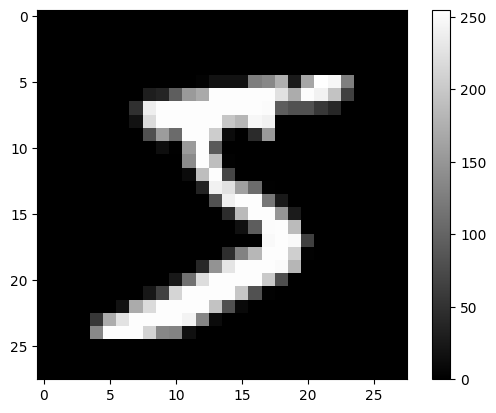

In [5]:
# 1個のデータを描画してみる
plt.imshow(x_train[0], cmap='gray') # matplotlibのimshow関数で画像で表示。cmapはカラーマップを変換してくれるパラメータ引数
plt.colorbar()
# カラーマップ一覧 -> https://matplotlib.org/examples/color/colormaps_reference.html

In [8]:
# 正規化処理なし
x_train = np.float32(x_train)
x_valid = np.float32(x_valid)

モデルの訓練をきちんと行うための必要事項:
1. データセットのデータがよくシャッフルされること
2. 適度な大きさでミニバッチ化される
3. データが高速に利用できる


In [9]:
# tf.dataを使う（tf.Tensorに変換）
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)) # 訓練セットの入力と教師ラベル合体させてTensorに変換
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)) # 検証も同様に処理

AUTOTUNE = tf.data.experimental.AUTOTUNE # 処理を最適化するためのおまじない（自動チューニング設定）
train_ds = train_ds.shuffle(len(x_train)) # 訓練データをシャッフルする。引数にはデータ数を指定すると完全なシャッフルが行われる。len(x_train)は60000。
train_ds = train_ds.repeat(1) # 1 epochで使われるデータの回数。1の場合，1epochで1回しか使われない。引数を空欄にすると無限に使われる。
train_ds = train_ds.batch(32) # ミニバッチを作る。1バッチ32個のデータ。
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE) # 訓練中に次のバッチを取り出すための処理。
valid_ds = valid_ds.batch(32) # 検証データはシャッフルする必要ないので，バッチ化のみの処理でOK。

**2. モデルの設計**

In [10]:
# 今回は Functional API を使ってみる。（今後こっちの書き方でやります）
input = Input(shape=(28, 28), name='input') # 入力層の定義
h = Flatten()(input) # 28x28の2次元テンソルを784次元の1次元テンソルに変換する。フラット化。
h = Dense(512, activation='relu', name='dense1')(h) # 隠れ層のノードは512
output = Dense(10, activation='softmax', name='output')(h) # 出力層

model = Model(inputs=input, outputs=output) # この処理でモデルを実体化する。入力層と出力層を渡すと自動的にネットワークを構築してくれる。
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense1 (Dense)              (None, 512)               401920    
                                                                 
 output (Dense)              (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


**3. 損失関数や最適化関数の定義**

In [11]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

**4. 訓練**

In [12]:
model.fit(train_ds, epochs=10, validation_data=valid_ds) # エポック数は10くらいで十分

Epoch 1/10
1875/1875 [==============================] - 12s 3ms/step - loss: 0.1975 - accuracy: 0.9419 - val_loss: 0.0928 - val_accuracy: 0.9724
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0807 - accuracy: 0.9749 - val_loss: 0.0758 - val_accuracy: 0.9751
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0527 - accuracy: 0.9846 - val_loss: 0.0653 - val_accuracy: 0.9803
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0368 - accuracy: 0.9883 - val_loss: 0.0708 - val_accuracy: 0.9796
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0273 - accuracy: 0.9912 - val_loss: 0.0676 - val_accuracy: 0.9791
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0217 - accuracy: 0.9931 - val_loss: 0.0649 - val_accuracy: 0.9821
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0172 - accuracy: 0.9944 - val_loss: 0.0868 - val_accuracy

正規化ありの訓練はこちらへ

In [13]:
# ここに正規化処理を入れる
x_train = np.float32(x_train) / 255.0
x_valid = np.float32(x_valid) / 255.0

In [14]:
# tf.Data準備
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)) # 訓練セットの入力と教師ラベル合体させてTensorに変換
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)) # 検証も同様に処理

AUTOTUNE = tf.data.experimental.AUTOTUNE # 処理を最適化するためのおまじない（自動チューニング設定）
train_ds = train_ds.shuffle(len(x_train)) # 訓練データをシャッフルする。引数にはデータ数を指定すると完全なシャッフルが行われる。len(x_train)は60000。
train_ds = train_ds.repeat(1) # 1 epochで使われるデータの回数。1の場合，1epochで1回しか使われない。引数を空欄にすると無限に使われる。
train_ds = train_ds.batch(32) # ミニバッチを作る。1バッチ32個のデータ。
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE) # 訓練中に次のバッチを取り出すための処理。
valid_ds = valid_ds.batch(32) # 検証データはシャッフルする必要ないので，バッチ化のみの処理でOK。

In [15]:
# モデル定義
input = Input(shape=(28, 28), name='input') # 入力層の定義
h = Flatten()(input) # 28x28の2次元テンソルを784次元の1次元テンソルに変換する。フラット化。
h = Dense(512, activation='relu', name='dense1')(h) # 隠れ層のノードは512
output = Dense(10, activation='softmax', name='output')(h) # 出力層

model = Model(inputs=input, outputs=output) # この処理でモデルを実体化する。入力層と出力層を渡すと自動的にネットワークを構築してくれる。
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 28, 28)]          0         
                                                                 
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense1 (Dense)              (None, 512)               401920    
                                                                 
 output (Dense)              (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

In [18]:
# 訓練
model.fit(train_ds, epochs=10, validation_data=valid_ds) # エポック数は10くらいで十分

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.8356 - accuracy: 0.7880 - val_loss: 0.3998 - val_accuracy: 0.8931
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3622 - accuracy: 0.8982 - val_loss: 0.3161 - val_accuracy: 0.9113
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3100 - accuracy: 0.9110 - val_loss: 0.2862 - val_accuracy: 0.9163
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2821 - accuracy: 0.9187 - val_loss: 0.2658 - val_accuracy: 0.9259
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2613 - accuracy: 0.9245 - val_loss: 0.2451 - val_accuracy: 0.9283
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2408 - accuracy: 0.9309 - val_loss: 0.2336 - val_accuracy: 0.9327
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2216 - accuracy: 0.9360 - val_loss: 0.2145 - val_accuracy:

In [19]:
model.save('mnist_dnn.h5') # モデルの保存。本当はGoogle Driveに保存したほうがよい。